## Apply binning

This notebook shows basic example implementations of binning an image.


### Well-behaved 2D Example

In [1]:
import numpy as np
import napari
from napari.utils import nbscreenshot

Small 2D example

In [2]:
array = np.arange(24).reshape(4, 6)
print("Original Array:")
print(array)

Original Array:
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]


In [3]:
n_rows, n_cols = array.shape[0], array.shape[1]
bin_rows = 2
bin_cols = 2

In [4]:
# Ensure binning is possible
# TO DO:
#  - if binning is not possible, choose a strategy to handle it, like ignoring exceeding pixels, or mirroring the array up to a size where it is possible, or padding the array with a constant value, etc (ignoring exceeding pixels is the simplest strategy)
#  - this can be applied whenever the image size is not divisible by the bin size
assert n_rows % bin_rows == 0, "Number of rows must be divisible by bin_rows"
assert n_cols % bin_cols == 0, "Number of columns must be divisible by bin_cols"

#### Reshaping and computing step-by-step

Reshaping into blocks

In [5]:
reshaped_array = array.reshape(n_rows // bin_rows, bin_rows, n_cols // bin_cols, bin_cols)
print('Reshaped Array:')
print(reshaped_array)

Reshaped Array:
[[[[ 0  1]
   [ 2  3]
   [ 4  5]]

  [[ 6  7]
   [ 8  9]
   [10 11]]]


 [[[12 13]
   [14 15]
   [16 17]]

  [[18 19]
   [20 21]
   [22 23]]]]


In [6]:
reshaped_array.shape

(2, 2, 3, 2)

Let's look at the top-left 4 pixels as an example (`0`, `1`, `6`, `7`). To have the image 2x2 binned, we need to have as the first pixel of the output `0 + 1 + 6 + 7 = 14`.
We start by summing over columns (last axis). This basically eliminates the last axis and allows us to compute `0 + 1 = 1` and `6 + 7 = 13` in different rows.

In [7]:
intermediary_result_1 = np.sum(reshaped_array, axis=-1)
print(intermediary_result_1)

[[[ 1  5  9]
  [13 17 21]]

 [[25 29 33]
  [37 41 45]]]


Now, all that is left to do is to sum over rows (second to last axis now). This computes the remaining necessary sum, which is `1 + 13 = 14` and allocates the result at the top-left pixel

In [8]:
binned_array = np.sum(intermediary_result_1, axis=-2)
print(binned_array)

[[14 22 30]
 [62 70 78]]


This can be done more directly as shown below.

*Notes:*
  - *the `-1` in the reshape can be used to automatically compute a suitable value for remaining dimension, if possible;*
  - *`axis` contains now `-3` and `-1` instead of `-2` and `-1` because they refer to the dimensions of the reshaped array, not to the shape of the intermediary results.*

In [9]:

# Reshape the array to divide it into bins
reshaped_array = array.reshape(n_rows // bin_rows, bin_rows, -1, bin_cols)

# Perform summing operation along the specified axes
binned_array = np.sum(reshaped_array, axis=(-3, -1))

print("Binned Array:")
print(binned_array)


Binned Array:
[[14 22 30]
 [62 70 78]]


#### Displaying results in napari

The first pixel coordinate is `(0,0)`, which is its center. In napari, this pixel is displayed as a square that goes from `-0.5` to `0.5` in x and y (see more details [in this issue](https://github.com/napari/napari/issues/2778))

The binned image has less pixels, so we upscale it using the binning factors to visualize both images with the same size.

After upscaling, the origin of the first pixel is still preserved as `(0,0)`, but, assuming we did a 2x2 binning, the pixel size is now 2x2.

This means this upscaled pixel is now represented by a squarethat goes from `(-1, -1)` to `(1, 1)`. This results in a visualization that is shifted by half a pixel in x and y.


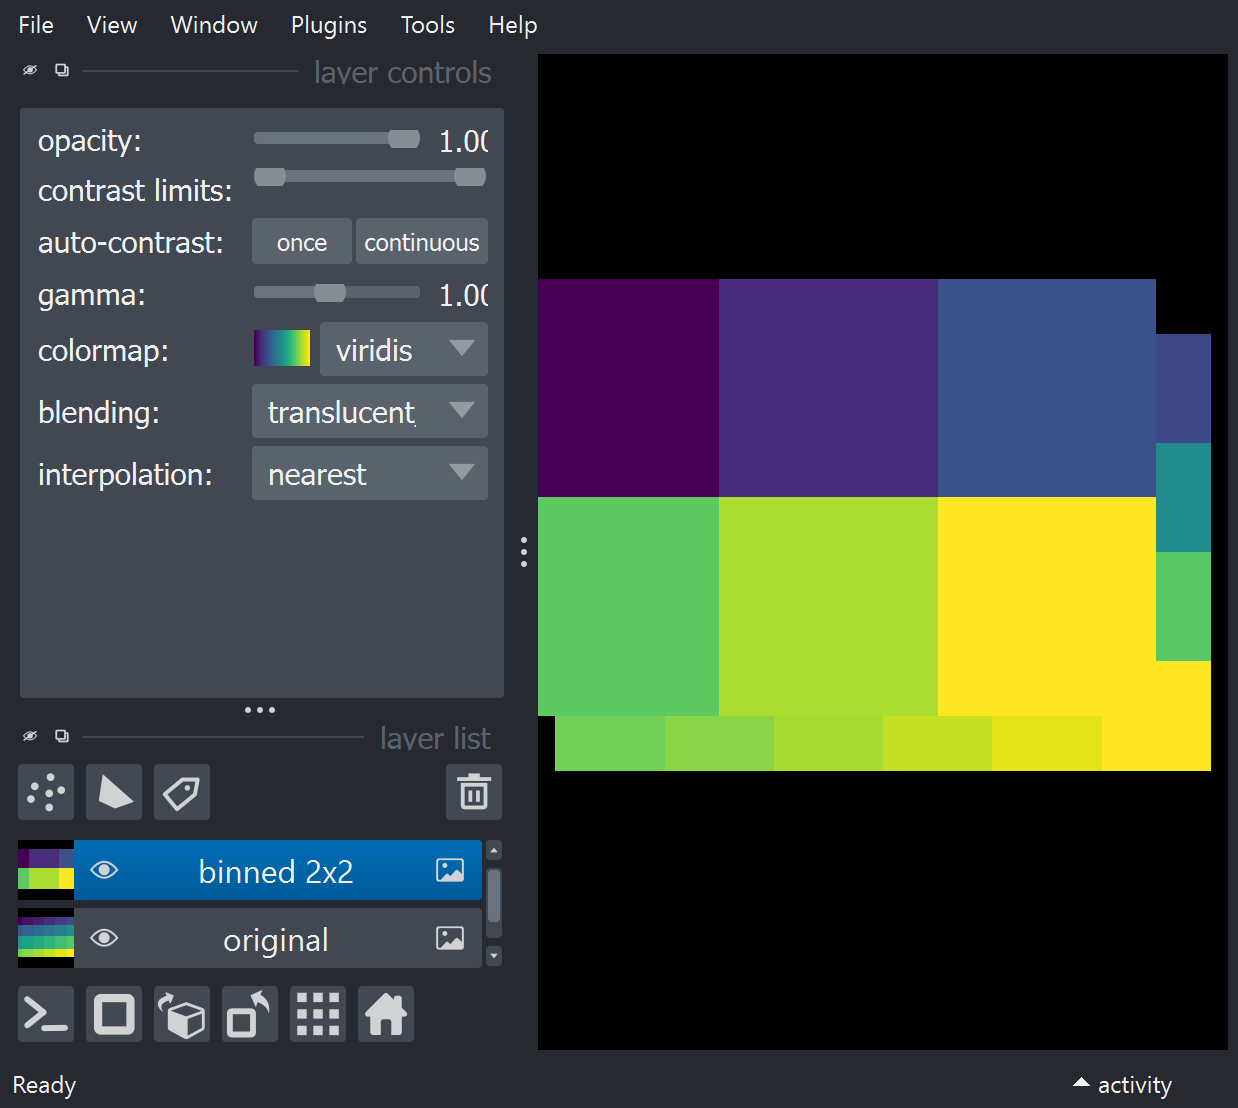

In [10]:
viewer = napari.Viewer()
array_layer = viewer.add_image(array, name='original', colormap='viridis')
# scale and translate are used to align the binned image againt the original image

binned_layer = viewer.add_image(binned_array, name='binned 2x2', scale=[bin_rows, bin_cols], colormap='viridis')
nbscreenshot(viewer)


To correct for this, we translate the binned image by half the bin size minus `0.5` (the original edge) in x and y (we shift the layer to force it to start at `-0.5`).

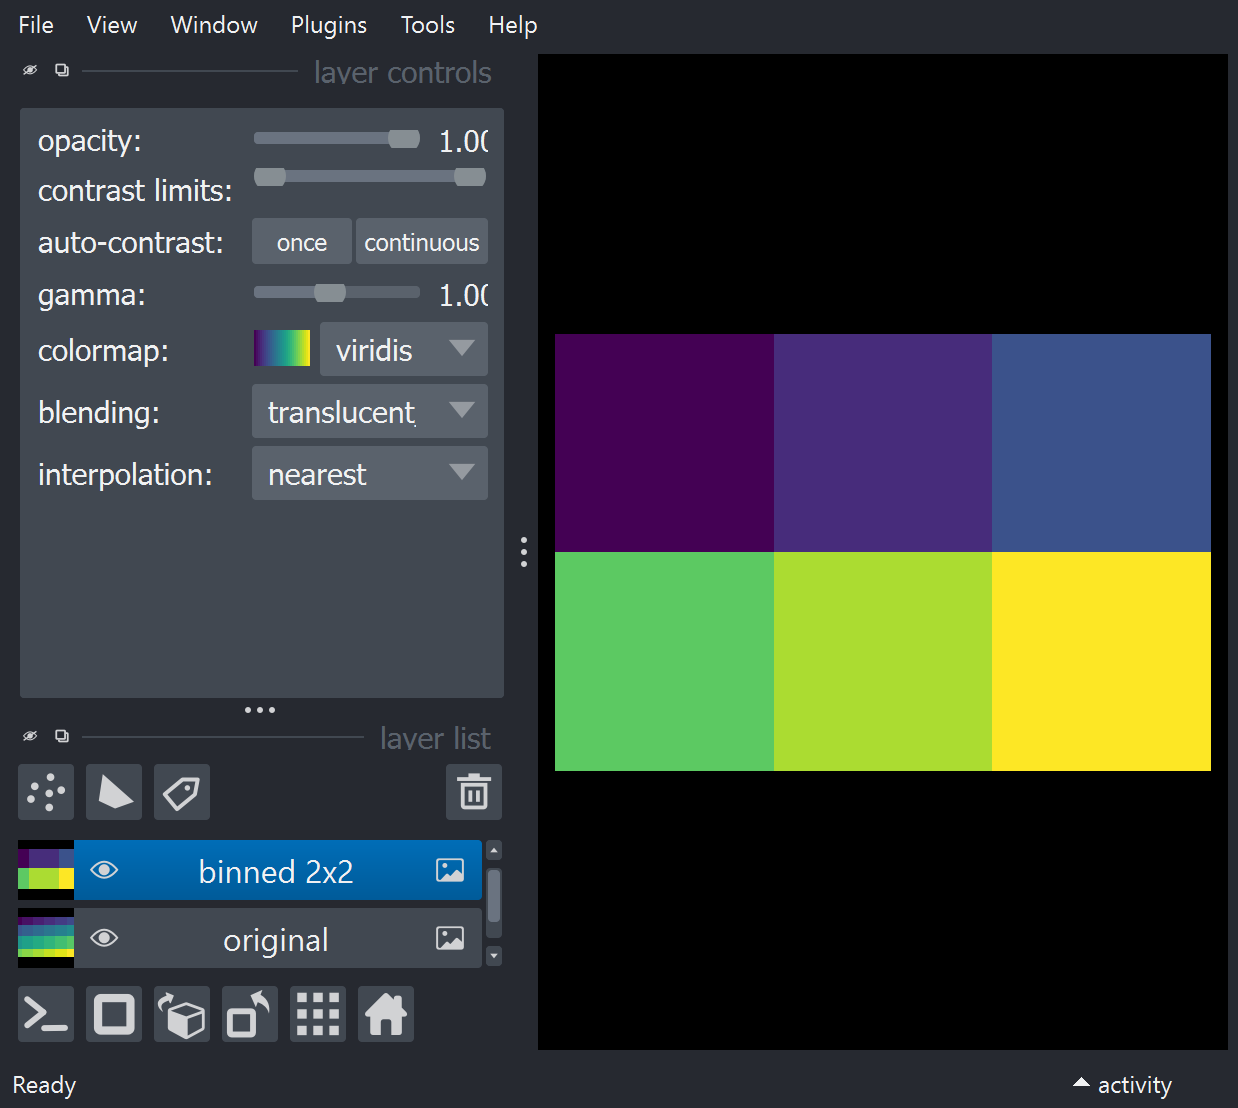

In [11]:
binned_layer.translate = [bin_rows/2 - 0.5, bin_cols/2 - 0.5]
nbscreenshot(viewer)

This also works for other binning options and we can do it in one shot.

Original Array:
[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]]
Binned Array:
[[ 24  42]
 [ 96 114]]


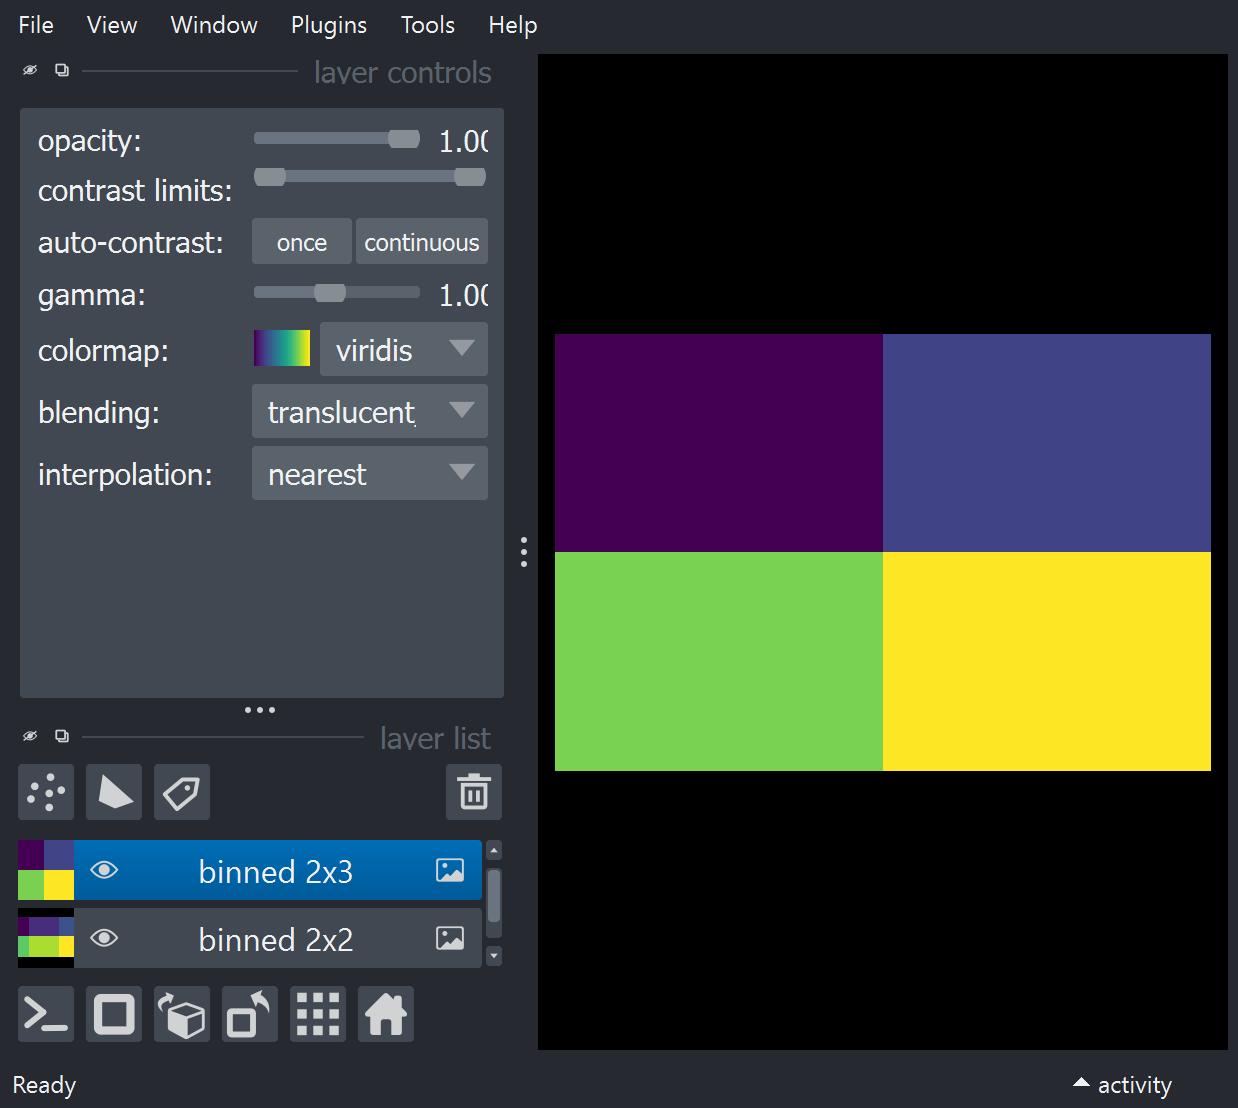

In [12]:
print("Original Array:")
print(array)

bin_rows = 2
bin_cols = 3

# Reshape the array to divide it into bins
reshaped_array = array.reshape(array.shape[0] // bin_rows, bin_rows, -1, bin_cols)

# Perform summing operation along the specified axes
binned_array = np.sum(reshaped_array, axis=(1, 3))

print("Binned Array:")
print(binned_array)

binned_layer2 = viewer.add_image(binned_array, name='binned 2x3', scale=[bin_rows, bin_cols], colormap='viridis', translate=[bin_rows/2 - 0.5, bin_cols/2 - 0.5])

nbscreenshot(viewer)


### Timelapse Example
Assuming time is the first dimension, the example array below can be seen as a timelapse with 2 time points. We just use a for loop to compute the binning for each timepoint and we previously build an empty array of appropriate shape to store the results.

In [13]:
array = np.arange(48).reshape(2, 4, 6)
print("Original Array:")
print(array)

n_time_points = array.shape[0]
n_rows = array.shape[-2] 
bin_rows = 2
bin_cols = 2

binned_array = np.zeros((n_time_points, n_rows // bin_rows, array.shape[-1] // bin_cols), dtype=array.dtype)
for t in range(n_time_points):
    reshaped_array = array[t].reshape(n_rows // bin_rows, bin_rows, -1, bin_cols)
    binned_array[t] = np.sum(reshaped_array, axis=(1, 3))

print("Binned Array:")
print(binned_array)

Original Array:
[[[ 0  1  2  3  4  5]
  [ 6  7  8  9 10 11]
  [12 13 14 15 16 17]
  [18 19 20 21 22 23]]

 [[24 25 26 27 28 29]
  [30 31 32 33 34 35]
  [36 37 38 39 40 41]
  [42 43 44 45 46 47]]]
Binned Array:
[[[ 14  22  30]
  [ 62  70  78]]

 [[110 118 126]
  [158 166 174]]]
